In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [21]:
class PublicGoodsModel():
    
    def plot_grid(self):
        plot_grid = np.zeros((self.width, self.height),dtype=np.float64)
        for x in range(self.width):
            for y in range(self.height):
                strat = self.grid[x][y].strategy
                if strat == 'D':
                    plot_grid[x][y] = 0
                else:
                    plot_grid[x][y] = 1
                #plot_grid[x][y] = self.grid[x][y].payoff
        #print(plot_grid)
        plt.imshow(plot_grid, interpolation='nearest')
        plt.colorbar()
    
    def __init__(self, density, width, height, r_factor, R1=1, R2=1):
        self.grid = np.zeros((width, height),dtype=EconomicAgent)
        self.width, self.height = width, height
        self.r_factor = r_factor
        self.R1, self.R2 = R1, R2
        self.b_pay = 2/self.r_factor
        self.c_pay = (R2-R1)/R1
        #self.grid = np.full((width, height), [0,0,0])
        ag_id = 0
        self.agents = []
        for x in range(self.width):
            for y in range(self.height):
                if density >= random.random():
                    ag = EconomicAgent(ag_id, random.randrange(1,10), self.width, self.height)
                    ag.set_coord(x,y)
                    self.agents.append(ag)
                    self.grid[x][y] = ag
                    #print(self.grid[x][y].wealth)
                    ag_id += 1
                else:
                    ag = EconomicAgent(ag_id, 0, self.width, self.height)
                    ag.set_coord(x,y)
                    self.agents.append(ag)
                    self.grid[x][y] = ag
                    ag_id += 1
        #print(self.grid)
        #plt.imshow(self.grid, interpolation='nearest')
        #plt.colorbar()
        
    def payoff_matrix(self, status_one, status_two, strat_one, strat_two):
        if status_one == 'Rich':
            if status_two == 'Rich':
                if strat_one == 'C':
                    if strat_two == 'C': # CC RICH-RICH
                        return (2*self.c_pay) + 1
                    else: # CD RICH-RICH
                        return self.c_pay
                else:
                    if strat_two == 'C': # DC RICH-RICH
                        return (self.c_pay*self.b_pay) + self.b_pay + self.c_pay
                    else: # DD RICH-RICH
                        return (self.c_pay*self.b_pay) + self.b_pay - 1
            else:
                if strat_one == 'C':
                    if strat_two == 'C': # CC RICH-POOR
                        return self.c_pay + 1
                    else: # CD RICH-POOR
                        return self.c_pay
                else:
                    if strat_two == 'C': # DC RICH-POOR
                        return (self.c_pay*self.b_pay) + self.b_pay
                    else: # DD RICH-POOR
                        return (self.c_pay*self.b_pay) + self.b_pay - 1
        else: # Poor
            if status_two == 'Rich':
                if strat_one == 'C':
                    if strat_two == 'C': # CC POOR-RICH
                        return self.c_pay + 1
                    else: # CD POOR-RICH
                        return 0
                else:
                    if strat_two == 'C': # DC POOR-RICH
                        return self.c_pay + self.b_pay
                    else: # DD POOR-RICH
                        return self.b_pay - 1
            else:
                if strat_one == 'C':
                    if strat_two == 'C': # CC POOR-POOR
                        return 1
                    else: # CD POOR-POOR
                        return 0
                else:
                    if strat_two == 'C': # DC POOR-POOR
                        return self.b_pay
                    else: # DD POOR-POOR
                        return self.b_pay - 1
                    
    def change_strategy(self, agent_strat, neighbors_strategy, neighbors_payoffs):
        total_payoff = sum(neighbors_payoffs)
        if total_payoff != 0:
            p = random.uniform(0,1)
            if p <= neighbors_payoffs[0]/total_payoff:
                return neighbors_strategy[0]
            elif p <= (neighbors_payoffs[0] + neighbors_payoffs[1])/total_payoff:
                return neighbors_strategy[1]
            elif p <= (neighbors_payoffs[0] + neighbors_payoffs[1] + neighbors_payoffs[2])/total_payoff:
                return neighbors_strategy[2]
            elif p <= (neighbors_payoffs[0] + neighbors_payoffs[1] + neighbors_payoffs[2] + neighbors_payoffs[3])/total_payoff:
                return neighbors_strategy[3]
            else:
                return neighbors_strategy[4]
        else:
            return neighbors_strategy[4]
        
    def step(self):
        for agent in self.agents:
            #print(agent.get_coord())
            neighbors = agent.get_neighbors(self.width, self.height)
            #print(neighbors)
            # self.activity, self.wealth, self.status, self.strategy
            agent_act, agent_wealth, agent_status, agent_strat = agent.get_general_status()
            if agent_act:
                for neighbor in neighbors:
                    act, wealth, status, strat = self.grid[neighbor[0]][neighbor[1]].get_general_status()
                    if act:
                        payoff = PublicGoodsModel.payoff_matrix(self, agent_status, status, agent_strat, strat)
                        agent.payoff += payoff
                        self.grid[neighbor[0]][neighbor[1]].payoff += payoff
        # CHANGE STRATEGY
        for agent in self.agents:
            neighbors = agent.get_neighbors(self.width, self.height)
            agent_act, agent_wealth, agent_status, agent_strat = agent.get_general_status()
            if agent_act:
                neighbors_payoff = []
                neighbors_strategy = []
                for neighbor in neighbors:
                    act, wealth, status, strat = self.grid[neighbor[0]][neighbor[1]].get_general_status()
                    if act:
                        neighbors_payoff.append(self.grid[neighbor[0]][neighbor[1]].payoff)
                        neighbors_strategy.append(self.grid[neighbor[0]][neighbor[1]].strategy)
                neighbors_payoff.append(agent.payoff)
                neighbors_strategy.append(agent_strat)
                agent.strategy = PublicGoodsModel.change_strategy(self, agent_strat, neighbors_strategy, neighbors_payoff)
            #print(agent.get_neighbors(self.width, self.height))
            #print(self.grid[up_n[0]][up_n[1]].wealth,end=', ')
            #print(self.grid[rig_n[0]][rig_n[1]].wealth,end=', ')
            #print(self.grid[lo_n[0]][lo_n[1]].wealth,end=', ')
            #print(self.grid[lef_n[0]][lef_n[1]].wealth)
            
            #print(self.grid[up_n[0]][up_n[1]].get_general_status(),end=', ')
            #print(self.grid[rig_n[0]][rig_n[1]].get_general_status(),end=', ')
            #print(self.grid[lo_n[0]][lo_n[1]].get_general_status(),end=', ')
            #print(self.grid[lef_n[0]][lef_n[1]].get_general_status())
        
'''
class PublicGoodsModel():
    
    def __init__(self, N, width, height):
        self.grid = np.zeros((width, height))
        for agent_n in range(N):
            ag = EconomicAgent(random.randrange(0,10), width, height)
            x,y = ag.get_coord()
            self.grid[x][y] = ag.wealth
        plt.imshow(self.grid, interpolation='nearest')
        plt.colorbar()
'''

class EconomicAgent():
    
    def set_coord(self, x, y):
        self.x = x
        self.y = y
    
    def __init__(self, ag_id, wealth, width, height, initial_strategy = 0.5):
        self.id = ag_id
        self.payoff = 0
        self.wealth = wealth
        if wealth == 0:
            self.activity = False # Dead Agent
        elif wealth < 5:
            self.activity = True # Alive
            self.status = 'Poor'
        else:
            self.activity = True # Alive
            self.status = 'Rich'
        # AGENT'S STRATEGY
        initial_strategy = initial_strategy*10
        if random.randrange(0,10) < initial_strategy:
            self.strategy = "D"
        else:
            self.strategy = "C"
        
    def get_neighbors(self, x_border, y_border, x_thresh=0, y_tresh=0):
        if type(x_border)==int and type(y_border)==int:
            # Horizontal Neighbors
            if self.x == x_border-1:
                right_neighbor = [0, self.y]
                left_neighbor = [self.x-1, self.y]
            elif self.x == 0:
                right_neighbor = [self.x+1, self.y]
                left_neighbor = [x_border-1, self.y]
            else:
                right_neighbor = [self.x+1, self.y]
                left_neighbor = [self.x-1, self.y]
            # Vertical Neighbors
            if self.y == y_border-1:
                upper_neighbor = [self.x, 0]
                lower_neighbor = [self.x, self.y-1]
            elif self.y == 0:
                upper_neighbor = [self.x, self.y+1]
                lower_neighbor = [self.x, y_border-1]
            else:
                upper_neighbor = [self.x, self.y+1]
                lower_neighbor = [self.x, self.y-1]
            # Clockwise direction 
            return upper_neighbor, right_neighbor, lower_neighbor, left_neighbor
        else:
            return None
        
    def get_general_status(self):
        return self.activity, self.wealth, self.status, self.strategy
        
    def get_coord(self):
        return self.x, self.y

"\nfor i in range(2):\n    model.step()\n    \nagent_counts = np.zeros((model.grid.width,model.grid.height))\nfor cell in model.grid.coord_iter():\n    print(cell)\n    cell_content, x, y = cell\n    agent_count = len(cell_content)\n    agent_counts[x][y] = agent_count\nplt.imshow(agent_counts, interpolation='nearest')\nplt.colorbar()\n"

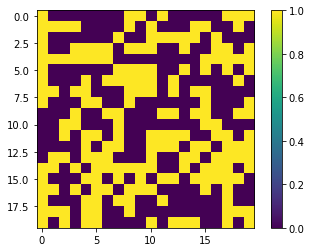

In [29]:
model = PublicGoodsModel(1,20,20,1.2, R1=2, R2=1)
model.plot_grid()



"""
for i in range(2):
    model.step()
    
agent_counts = np.zeros((model.grid.width,model.grid.height))
for cell in model.grid.coord_iter():
    print(cell)
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()
"""

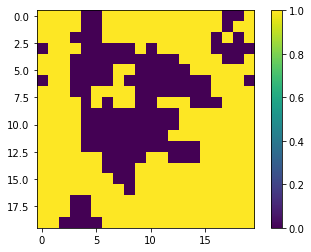

In [30]:
for x in range(10):
    model.step()
model.plot_grid()